# Building brain-realism into AI models

#1. Network Architecture

One significant distinction between biological neural systems and most artificial models is the presence of different cell types, specifically **excitatory and inhibitory neurons**.

Let's create a Leaky RNN with excitatory and inhibitory units (artificial neurons). This section is based on the paper by [Song et al., 2016](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004792)

### 2.1.1 Define an E-I recurrent network

Here we define a E-I recurrent network, in particular, no self-connections are allowed.

* EIRecLinear Class performs a recurrent excitatory-inhibitory linear transformation.
* The network divides its neurons into excitatory (e_size) and inhibitory (i_size) groups.
* The mask ensures that connections from excitatory neurons have positive weights and connections from inhibitory neurons have negative weights.
* The effective_weight method returns the modified weight matrix, where each weight is multiplied by its corresponding value in the mask.
* During the forward pass, this weight matrix is used to determine how the input is transformed.


**Mask usage in the EIRecLinear model:**

When computing the effective weight, the mask is applied to the absolute value of the weight
matrix. This operation ensures that the weights have the correct sign (positive or negative)
while maintaining their magnitudes, thus preserving the designated E-I structure during training.

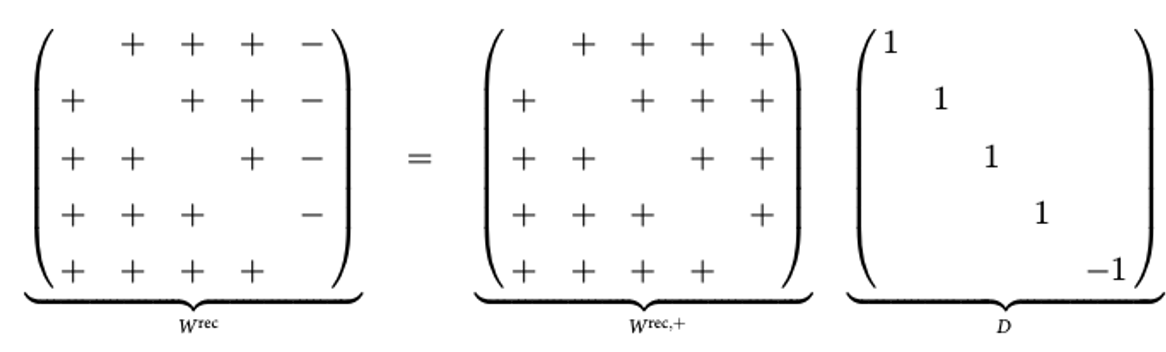


In [1]:
import numpy as np
import numpy.matlib

num_units_rec = 5
e_size = 4
i_size = num_units_rec - e_size

# mask_EI_vec = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T
# mask_EI_mat_plusdiag = np.matlib.repmat(mask_EI_vec,num_units_rec,1)
# diag_mat = np.zeros((num_units_rec,num_units_rec)) + np.diag(np.ones((num_units_rec)))
# mask_EI_mat = mask_EI_mat_plusdiag - diag_mat

mask_no_diag = np.ones((num_units_rec,num_units_rec)) -  np.diag(np.ones((num_units_rec)))

E_I_unit_list = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T

E_I_mask = mask_no_diag*E_I_unit_list

print(E_I_mask)

[[ 0.  1.  1.  1. -1.]
 [ 1.  0.  1.  1. -1.]
 [ 1.  1.  0.  1. -1.]
 [ 1.  1.  1.  0. -1.]
 [ 1.  1.  1.  1. -0.]]


In [2]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math


class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)


EIRNN class defines the EI-RNN model.

* It uses EIRecLinear to establish excitatory-inhibitory dynamics in the recurrent connections.
* The recurrence method takes input and the hidden state to compute the total input to the next layer using both input-to-hidden and hidden-to-hidden connections.
* The dynamics between excitatory and inhibitory units are determined by the transformation in the EIRecLinear layer (via the self.h2h module).


In [3]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [4]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [5]:
# %%capture
# # @title Generating dataset from a perceptual decision making task
# ! git clone https://github.com/neurogym/neurogym.git
# %cd neurogym/
# ! pip install -e .

In [ ]:
%%capture
# @title import the task from the neurogym library

import neurogym.neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.data.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

AttributeError: module 'neurogym' has no attribute 'data'

### Train the network on the decision making task

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


NameError: name 'input_size' is not defined

In [ ]:
# @title Run the network post-training and record neural activity

env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


Average performance 0.812


Text(0, 0.5, 'Activity')

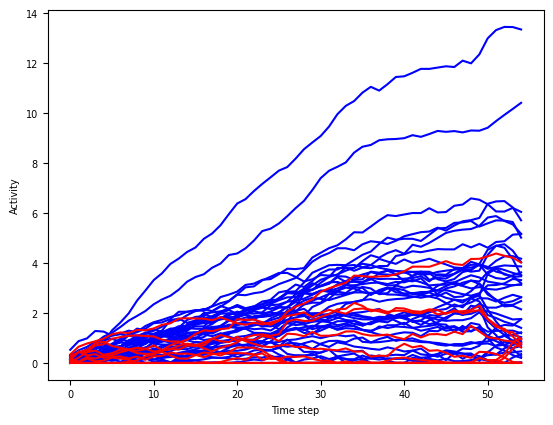

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

e_size = net.rnn.e_size
trial = 2

plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')

In [ ]:
# @title Compute stimulus selectivity for sorting neurons

# Here for each neuron we compute its stimulus period selectivity

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))


Text(0.5, 1.0, 'Network connectivity')

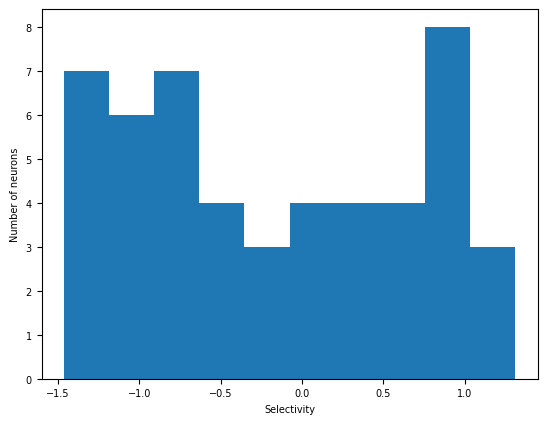

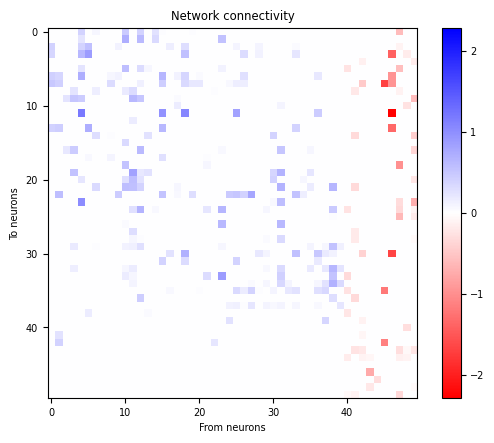

In [ ]:
# @title Plot network connectivity sorted by stimulus selectivity

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# Plot distribution of stimulus selectivity
plt.figure()
plt.hist(selectivity)
plt.xlabel('Selectivity')
plt.ylabel('Number of neurons')

W = net.rnn.h2h.effective_weight().detach().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons')
plt.ylabel('To neurons')
plt.title('Network connectivity')

# 3. Objective Functions:

In this section, we will adapt our objective function to penalise long-distance connections. This section is based on the paper [Achterberg et al., Nature Machine Intelligence, 2023](https://www.nature.com/articles/s42256-023-00748-9)



## Bringing Brain Realism to Objectives:

While many neural networks in machine learning are optimized purely for performance on a task, the brain operates under numerous constraints. It balances the need to process information efficiently with physical and metabolic costs. This makes the objectives for models inspired by the brain, like the spatially-embedded RNNs (seRNNs), slightly different.

**Spatially-Embedded Recurrent Neural Networks (seRNNs): A Brain-Realistic Objective**

The seRNN incorporates these biological constraints into its objective by introducing a 3D Euclidean space in which each neuron exists.

Optimization Terms:
The general loss function for a regularized network can be given as:

$J = J_{task} + J1= J_{task} + \gamma \|W\|$

Where $L_{task}$ is the task loss, $\gamma$ is a regularization parameter, and $\|W\|$ is the L1 norm of the recurrent weight matrix $W$, defined as:

$\|W\| = \sum_{i=1}^{m} \sum_{j=1}^{m} |w_{i,j}|$

In the context of seRNNs, to emphasize the importance of spatial constraints, a distance matrix $D$ representing the physical distances between neurons is introduced. The optimization term with the distance matrix becomes:

$J = J_{task} + \gamma \|W \odot D\|$

Where $\odot$ denotes the Hadamard (element-wise) product, and the spatially regularized term is:

$\|W \odot D\| = \sum_{i=1}^{m} \sum_{j=1}^{m} |w_{i,j}| \times |d_{i,j}|$




In [ ]:
import torch
from torch import nn
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
class Reg_WD(torch.nn.Module):

    """A regulariser for spatially embedded RNNs.
  Applies L1 regularisation to recurrent kernel of
  RNN which is weighted by the distance of units
  in predefined 3D space.
  Calculation:
      reg_WD * sum[distance_matrix o recurrent_kernel]
  Attributes:
      reg_WD: Float; Weighting of Reg_WD regularisation term.
      network_structure: Defines a 3D grid specifying the
      dimensions of a 3D space where neurons are placed.
      The tuple specifies the range of coordinates along
      each of the three axes in this 3D space.
  """

    def __init__(self, reg_WD=0.01, neuron_num=100, network_structure=(5,5,4), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        super(Reg_WD, self).__init__()

        self.distance_power = distance_power
        self.reg_WD = torch.tensor([reg_WD], dtype=torch.float32)

        # Set up tensor with distance matrix
        nx = np.arange(network_structure[0])
        ny = np.arange(network_structure[1])
        nz = np.arange(network_structure[2])

        # Set up coordinate grid
        x, y, z = np.meshgrid(nx, ny, nz)
        self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

        # Override coordinate grid if provided in init
        if coordinates_list is not None:
            self.coordinates = coordinates_list

        # Check neuron number / number of coordinates
        if (len(self.coordinates[0]) == neuron_num) and (len(self.coordinates[1]) == neuron_num) and (len(self.coordinates[2]) == neuron_num):
            pass
        else:
            raise ValueError('Network / coordinate structure does not match the number of neurons.')

        # Calculate the euclidean distance matrix
        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
        euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
        self.distance_matrix = torch.tensor(euclidean, dtype=torch.float32)

    def forward(self, x):
        abs_weight_matrix = torch.abs(x)
        WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
        return WD_loss

    def _check_penalty_number(self, x):
        if not isinstance(x, (float, int)):
            raise ValueError(('Value: {} is not a valid regularization penalty number, '
                              'expected an int or float value').format(x))

    def visualise_distance_matrix(self):
        plt.imshow(self.distance_matrix.numpy())
        plt.colorbar()
        plt.show()

    def visualise_neuron_structure(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(self.coordinates[0], self.coordinates[1], self.coordinates[2], c='b', marker='.')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    def get_config(self):
        return {'reg_WD': float(self.reg_WD)}


In [ ]:
class seRNN(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int,
        device: str,
        add_noise: bool = True,
        noise_std: float = 0.05,
    ):
        super(seRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.add_noise = add_noise
        self.noise_std = noise_std

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)



    def forward(self, x):
        if self.add_noise:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        out, _ = self.rnn(x)
        out = self.output_layer(out[:, -1, :])
        return out


In [ ]:
# @title Definition of a task and generation of dataset for model training

class mazeGeneratorI():
    '''
    Objects of the mazeGeneratorI class can create numpy and tf datasets of the first choice of the maze task.
    Task structure:
        Goal presentation, followed by delay period, followed by choice options.
    Response:
        One response required from agent at end of episode. Direction (Left, Up, Right, Down) of first step.
    Encoding:
        Both observations and labels are OneHot encoded.
    Usage:
        The two only function a user should need to access are "construct_numpy_data" and "construct_tf_data"
    Options:
        Both data construction methods have an option to shuffle the labels of data.
        The numpy data construction method allows to also return the maze identifiers.
    '''
    def __init__(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.version = 'v1.2.0'

        # Import variables defining episode
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

        # Construct mazes dataframe
        ## Add encoded versions of the goal / choices presentations and the next step response
        self.mazesdf = self.import_maze_dic()
        self.mazesdf['Goal_Presentation'] = self.mazesdf['goal'].map({
            7:np.concatenate((np.array([1,0,0,0]),np.repeat(0,4))),
            9:np.concatenate((np.array([0,1,0,0]),np.repeat(0,4))),
            17:np.concatenate((np.array([0,0,1,0]),np.repeat(0,4))),
            19:np.concatenate((np.array([0,0,0,1]),np.repeat(0,4)))})
        self.mazesdf['Choices_Presentation']=self.mazesdf['ChoicesCategory'].map(lambda x: self.encode_choices(x=x))
        self.mazesdf['Step_Encoded']=self.mazesdf['NextFPmap'].map(lambda x: self.encode_next_step(x=x))

    def construct_numpy_data(self, number_of_problems, return_maze_identifiers = False, np_shuffle_data = False):
        # Create a new column which hold the vector for each problem
        self.mazesdf['Problem_Vec']=self.mazesdf.apply(lambda x: self.create_problem_observation(row= x,goal_presentation_steps= self.goal_presentation_steps,delay_steps= self.delay_steps,choices_presentation_steps= self.choices_presentation_steps), axis=1)
        # Set a random order of maze problems for the current session
        self.mazes_order = np.random.randint(0,8,number_of_problems)

        # Create vectors, holding observations and labels
        session_observation =np.array([])
        session_labels = np.array([])
        for i in self.mazes_order:
            session_observation = np.append(session_observation,self.mazesdf.iloc[i]['Problem_Vec'])
            session_labels = np.append(session_labels,self.mazesdf.iloc[i]['Step_Encoded'])

        # Reshape vectors to fit network observation and response space
        session_length = self.goal_presentation_steps + self.delay_steps + self.choices_presentation_steps
        session_observation = np.reshape(session_observation, (-1,session_length,8)).astype('float32')
        session_labels = np.reshape(session_labels, (-1,4)).astype('float32')

        # If np_shuffle_data == 'Labels, the order of labels is shuffled to randomise correct answers
        if np_shuffle_data == 'Labels':
          shuffle_generator = np.random.default_rng(38446)
          shuffle_generator.shuffle(session_labels,axis=0)

        # If return_maze_identifiers == 'IDs', return the array with maze IDs alongside the regular returns (observations, labels)
        if return_maze_identifiers == 'IDs':
          return session_observation, session_labels, self.mazes_order

        return session_observation, session_labels

    def reset_construction_params(self, goal_presentation_steps, delay_steps, choices_presentation_steps):
        self.goal_presentation_steps = goal_presentation_steps
        self.delay_steps = delay_steps
        self.choices_presentation_steps = choices_presentation_steps

    def import_maze_dic(self, mazeDic=None):
        if mazeDic == None:
            # Set up dataframe with first choices of maze task
            ## The dictionary was generated using MazeMetadata.py (v1.0.0) and the following call:
            ### mazes.loc[(mazes['Nsteps']==2)&(mazes['ChoiceNo']=='ChoiceI')][['goal','ChoicesCategory','NextFPmap']].reset_index(drop=True).to_dict()
            self.mazesDic = {'goal': {0: 9, 1: 9, 2: 19, 3: 17, 4: 17, 5: 7, 6: 19, 7: 7},
            'ChoicesCategory': {0: 'ul',
            1: 'rd',
            2: 'ld',
            3: 'rd',
            4: 'ul',
            5: 'ur',
            6: 'lr',
            7: 'lr'},
            'NextFPmap': {0: 'u', 1: 'r', 2: 'd', 3: 'd', 4: 'l', 5: 'u', 6: 'r', 7: 'l'}}
        else:
            self.mazesDic = mazeDic

        # Create and return dataframe
        return pd.DataFrame(self.mazesDic)

    def encode_choices(self, x):
        # Helper function to create the observation vector for choice periods
        choices_sec = np.repeat(0,4)
        choicesEncoding = pd.Series(list(x))
        choicesEncoding = choicesEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedChoice in choicesEncoding:
            choices_sec[encodedChoice-1]=1
        return np.concatenate((np.repeat(0,4),choices_sec))

    def encode_next_step(self, x):
        # Helper function to change the response / action to a OneHot encoded vector
        step_sec = np.repeat(0,4)
        stepEncoding = pd.Series(list(x))
        stepEncoding = stepEncoding.map({'l':1,'u':2,'r':3,'d':4})
        for encodedStep in stepEncoding:
            step_sec[encodedStep-1]=1
        return step_sec

    def create_problem_observation(self, row, goal_presentation_steps, delay_steps, choices_presentation_steps):
        # Helper function to create one vector describing the entire outline of one maze problem (Goal presentation, Delay Period, and Choices Presentation)
        goal_vec = np.tile(row['Goal_Presentation'], goal_presentation_steps)
        delay_vec = np.tile(np.repeat(0,8), delay_steps)
        choices_vec = np.tile(row['Choices_Presentation'], choices_presentation_steps)
        problem_vec = np.concatenate((goal_vec,delay_vec,choices_vec))
        return problem_vec

    def __repr__(self):
        return '\n'.join([
            f'Maze DataSet Generator',
            f'Goal Presentation Steps: {self.goal_presentation_steps}',
            f'Delay Steps: {self.delay_steps}',
            f'Choices Presentation Steps: {self.choices_presentation_steps}'])



In [ ]:
#@title Generate datasets for training

from torch.utils.data import DataLoader, TensorDataset

# Generate numpy data using `construct_numpy_data` method from `gen` instance
gen = mazeGeneratorI(goal_presentation_steps=20, delay_steps=10, choices_presentation_steps=20)
train_data, train_labels = gen.construct_numpy_data(number_of_problems=5120)
test_data, test_labels = gen.construct_numpy_data(number_of_problems=2560)
val_data, val_labels = gen.construct_numpy_data(number_of_problems=2560)

# Create DataLoader from numpy arrays
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))
test_loader = DataLoader(test_dataset, batch_size=128)

val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
val_loader = DataLoader(val_dataset, batch_size=128)

#### Training and validation

In [ ]:
import torch.optim as optim
from torch.nn.functional import cross_entropy

# Each data sample in the dataset has a shape (seq_length, num_features)

input_size = train_data.shape[2] # input_size = num_features

device = "cuda" if torch.cuda.is_available() else "cpu" # Define 'device' here

model = seRNN(input_size=input_size, hidden_size=100, num_layers=1, num_classes=4, device="cuda" if torch.cuda.is_available() else "cpu").to(device)

# cost and optimizer
criterion = cross_entropy
optimizer = optim.Adam(model.parameters())

# Regularizer
# set reg_WD=0.3, number of neurons as 100 and network_structure=(5,5,4)
WD_regularizer = Reg_WD(reg_WD=0.3, neuron_num=100, network_structure=(5,5,4))


# To store RNN weight matrices
rnn_weight_matrices = []

train_cost = []


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_cost = 0.0  # Reset cost for each epoch


    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)

        # Main cost
        cost = criterion(outputs, torch.argmax(batch_labels, dim=1))

        # Add regularization cost
        # apply the WD_regularizer you defined to the RNN hidden layer weights (model.rnn.weight_hh_l0)
        WD_cost = WD_regularizer(model.rnn.weight_hh_l0)
        total_cost = cost + WD_cost
        epoch_cost += total_cost.item()


        # Backward pass and optimization
        optimizer.zero_grad()
        total_cost.backward()
        optimizer.step()

    epoch_cost /= len(train_loader)
    train_cost.append(epoch_cost)

    # Log RNN weight matrix after each epoch
    rnn_weight_matrices.append(model.rnn.weight_ih_l0.detach().clone())


    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == torch.argmax(batch_labels, dim=1)).sum().item()

    print(f"Epoch [{epoch+1}/{num_epochs}], cost: {total_cost.item():.4f}")


Epoch [1/10], cost: 174.3518
Epoch [2/10], cost: 25.1061
Epoch [3/10], cost: 2.8011
Epoch [4/10], cost: 1.7445
Epoch [5/10], cost: 1.6903
Epoch [6/10], cost: 1.6449
Epoch [7/10], cost: 1.5967
Epoch [8/10], cost: 1.5614
Epoch [9/10], cost: 1.6406
Epoch [10/10], cost: 1.5705


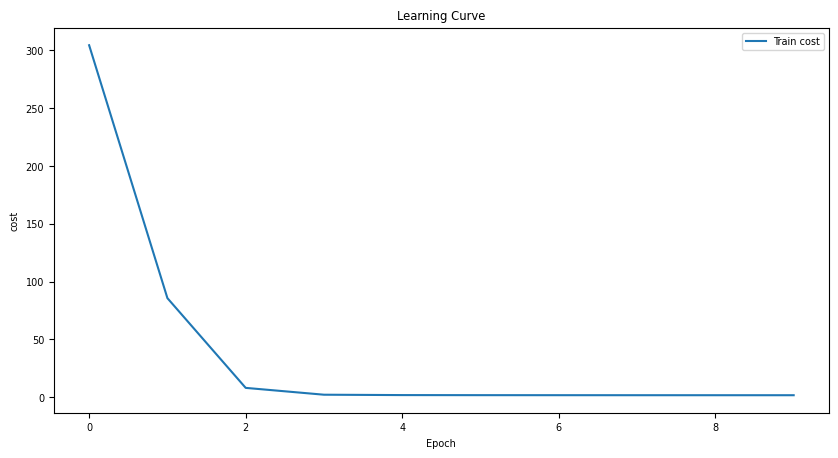

In [ ]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_cost, label='Train cost')
plt.xlabel('Epoch')
plt.ylabel('cost')
plt.title('Learning Curve')
plt.legend()
plt.show()


[link text](https://)# 4. Learning Rules


## 4. Learning Rules - Random Feedback Local Online learning (RFLO)


**Moving Towards Biological Plausibility with RFLO:**

RFLO employs a more "local" method of learning compared to backpropagation through tie:

* Random Feedback: Instead of requiring exact error information from the subsequent layers (as in BPTT), RFLO uses a fixed random matrix to project the output error.

* Local Learning: RFLO is designed to ensure that weight updates depend only on local pre- and post-synaptic activity. This means that for any given neuron or synapse, the weight adjustments are determined by the activities directly associated with them, rather than needing global network information.

* Online Learning: RFLO performs weight updates in real-time, or "online", as the RNN is run.







In the following example, random feedback local online (RFLO) learning is used to train a recurrent neural network (RNN) to produce a one-dimensional periodic output. Another RNN is trained using backpropagation through time (BPTT), and the performance of the two methods is compared.

The following code is adapted from the original paper by James M. Murray (2019) "[Local online learning in recurrent networks with random feedback](https://doi.org/10.7554/eLife.43299)"

In [ ]:
from pylab import *
from numpy import pi, arange

%matplotlib inline
import matplotlib.pyplot as plt

def theta(x):
    return 0.5*(1 + sign(x))


def f(x):
    return np.tanh(x)


def df(x):
    return 1/np.cosh(10*np.tanh(x/10))**2  # the tanh prevents overflow


class RNN:
    '''
    A recurrent neural network.

    Parameters:
    ----------
    n_in, n_rec, n_out : number of input, recurrent, and hidden units.

    h0 : The initial state vector of the RNN.

    tau_m : The network time constant, in units of timesteps.
    '''

    def __init__(self, n_in, n_rec, n_out, h0, tau_m=10):
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out
        self.h0 = h0
        self.tau_m = tau_m

        # Initialize weights:
        self.w_in = 0.1*(np.random.rand(n_rec, n_in) - 1)
        self.w_rec = 1.5*np.random.randn(n_rec, n_rec)/n_rec**0.5
        self.w_out = 0.1*(2*np.random.rand(n_out, n_rec) - 1)/n_rec**0.5

        # Random error feedback matrix:
        self.b = np.random.randn(n_rec, n_out)/n_out**0.5


    def run_trial(self, x, y_, eta=[0.1, 0.1, 0.1],
                  learning=None, online_learning=False):
        '''
        Run the RNN for a single trial.

        Parameters:
        -----------
        x : The input to the network. x[t,i] is input from unit i at timestep t.

        y_ : The target RNN output, where y_[t,i] is output i at timestep t.

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.

        Returns:
        --------
        y : The time-dependent network output. y[t,i] is output i at timestep t.

        h : The time-dependent RNN state vector. h[t,i] is unit i at timestep t.

        u : The inputs to RNN units (feedforward plus recurrent) at each
            timestep.
        '''

        # Boolean shorthands to specify learning algorithm:
        rtrl = learning is 'rtrl'
        bptt = learning is 'bptt'
        rflo = learning is 'rflo'

        [eta3, eta2, eta1] = eta  # learning rates for w_in, w_rec, and w_out
        t_max = np.shape(x)[0]  # number of timesteps

        dw_in, dw_rec, dw_out = 0, 0, 0  # changes to weights

        u = np.zeros((t_max, self.n_rec))  # input (feedforward plus recurrent)
        h = np.zeros((t_max, self.n_rec))  # time-dependent RNN activity vector
        h[0] = self.h0  # initial state
        y = np.zeros((t_max, self.n_out))  # RNN output
        err = np.zeros((t_max, self.n_out))  # readout error

        # If rflo, eligibility traces p and q should have rank 2; if rtrl, rank 3:
        if rtrl:
            p = np.zeros((self.n_rec, self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_rec, self.n_in))
        elif rflo:
            p = np.zeros((self.n_rec, self.n_rec))
            q = np.zeros((self.n_rec, self.n_in))

        for jj in range(self.n_rec):
            if rtrl:
                q[jj, jj, :] = df(u[0, jj])*x[0,:]/self.tau_m
            elif rflo:
                q[jj, :] = df(u[0, jj])*x[0,:]/self.tau_m

        for tt in range(t_max-1):
            u[tt+1] = np.dot(self.w_rec, h[tt]) + np.dot(self.w_in, x[tt+1])
            h[tt+1] = h[tt] + (-h[tt] + f(u[tt+1]))/self.tau_m
            y[tt+1] = np.dot(self.w_out, h[tt+1])
            err[tt+1] = y_[tt+1] - y[tt+1]  # readout error

            if rflo:
                p = (1-1/self.tau_m)*p
                q = (1-1/self.tau_m)*q
                p += np.outer(df(u[tt+1,:]), h[tt,:])/self.tau_m
                q += np.outer(df(u[tt+1,:]), x[tt,:])/self.tau_m
            elif rtrl:
                p = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, p, axes=1)
                q = np.tensordot((1-1/self.tau_m)*np.eye(self.n_rec)
                    + df(u[tt+1])*self.w_rec/self.tau_m, q, axes=1)
                for jj in range(self.n_rec):
                    p[jj, jj, :] += df(u[tt+1, jj])*h[tt]/self.tau_m
                    q[jj, jj, :] += df(u[tt+1, jj])*x[tt+1]/self.tau_m

            if rflo and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_rec))*p/t_max
                dw_in = eta3*np.outer(np.dot(self.b, err[tt+1]),
                                      np.ones(self.n_in))*q/t_max
            elif rflo and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2*np.outer(np.dot(self.b, err[tt+1]),
                                        np.ones(self.n_rec))*p/t_max
                dw_in += eta3*np.outer(np.dot(self.b, err[tt+1]),
                                       np.ones(self.n_in))*q/t_max
            elif rtrl and online_learning:
                dw_out = eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec = eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in = eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)
            elif rtrl and not online_learning:
                dw_out += eta1/t_max*np.outer(err[tt+1], h[tt+1])
                dw_rec += eta2/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), p, axes=1)
                dw_in += eta3/t_max*np.tensordot(
                    np.dot(err[tt+1], self.w_out), q, axes=1)

            if online_learning and not bptt:
                self.w_out = self.w_out + dw_out
                self.w_rec = self.w_rec + dw_rec
                self.w_in = self.w_in + dw_in

        if bptt:  # backward pass for BPTT
            z = np.zeros((t_max, self.n_rec))
            z[-1] = np.dot((self.w_out).T, err[-1])
            for tt in range(t_max-1, 0, -1):
                z[tt-1] = z[tt]*(1 - 1/self.tau_m)
                z[tt-1] += np.dot((self.w_out).T, err[tt])
                z[tt-1] += np.dot(z[tt]*df(u[tt]), self.w_rec)/self.tau_m

                # Updates for the weights:
                dw_out += eta1*np.outer(err[tt], h[tt])/t_max
                dw_rec += eta2/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                            h[tt-1])
                dw_in += eta3/(t_max*self.tau_m)*np.outer(z[tt]*df(u[tt]),
                                                           x[tt])

        if not online_learning:  # wait until end of trial to update weights
            self.w_out = self.w_out + dw_out
            self.w_rec = self.w_rec + dw_rec
            self.w_in = self.w_in + dw_in

        return y, h, u


    def run_session(self, n_trials, x, y_, eta=[0.1, 0.1, 0.1],
                    learning=None, online_learning=False):
        '''
        Run the RNN for a session consisting of many trials.

        Parameters:
        -----------
        n_trials : Number of trials to run the RNN

        x : The time-dependent input to the RNN (same for each trial).

        y_ : The target RNN output (same for each trial).

        eta : A list of 3 learning rates, for w_in, w_rec, and w_out,
            respectively.

        learning : Specify the learning algorithm with one of the following
            strings: 'rtrl', 'bptt', or 'rflo'. If None, run the network without
            learning.

        online_learning : If True (and learning is on), update weights at each
            timestep. If False (and learning is on), update weights only at the
            end of each trial. Online learning cannot be used with BPTT.


        Returns:
        --------
        y : The RNN output.

        loss_list : A list with the value of the loss function for each trial.

        readout_alignment : The normalized dot product between the vectorized
            error feedback matrix and the readout matrix, as in Lillicrap et al
            (2016).
        '''

        t_max = np.shape(x)[0]  # number of timesteps
        loss_list = []
        readout_alignment = []

        # Flatten the random feedback matrix(rfm) to check for feedback alignment:
        # As a guide, the total number of elements in bT_flat will determined by n_rows(rfm)*n_cols(rfm)
        bT_flat = np.reshape((self.b).T,(np.shape(self.b)[0]*np.shape(self.b)[1]))

        bT_flat = bT_flat/norm(bT_flat)

        for ii in range(n_trials):
            y, h, u = self.run_trial(x, y_, eta, learning=learning,
                                     online_learning=online_learning)

            err = y_ - y
            loss = 0.5*np.mean(err**2)
            loss_list.append(loss)

            w_out_flat = np.reshape((self.w_out),(np.shape(self.w_out)[0]*np.shape(self.w_out)[1]))
            w_out_flat = w_out_flat/norm(w_out_flat)
            readout_alignment.append(np.dot(bT_flat, w_out_flat))
            print('\r'+str(ii+1)+'/'+str(n_trials)+'\t Err:'+str(loss), end='')

        return y, loss_list, readout_alignment



Training with BPTT...
10000/10000	 Err:0.00032684208764531715
Training with RFLO...
10000/10000	 Err:0.00039652627402873294

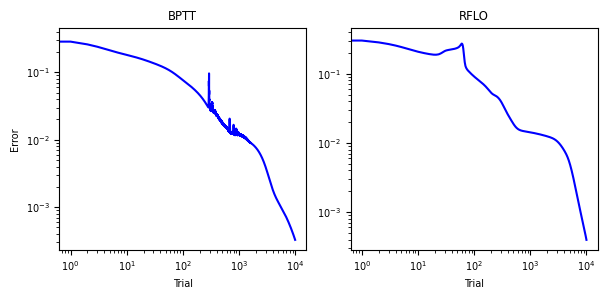

In [ ]:
# Compare RFLO learning, RTRL, and BPTT for producing a simple periodic output.

n_in, n_rec, n_out = 1, 50, 1  # number of inputs, recurrent units, and outputs
duration = 100  # number of timesteps in one period

# Input to RNN
x_tonic = 0.0*np.ones((duration, n_in))

# Target RNN output:
y_target = np.outer(np.sin(2*pi*arange(duration)/duration)
                    + 0.5*np.sin(2*2*np.pi*arange(duration)/duration)
                    + 0.25*np.sin(4*2*np.pi*arange(duration)/duration), np.ones(n_out))

n_tr = 10000  # number of trials to train on

h_init = 0.1*np.ones(n_rec)  # initial state of the RNN

print('\nTraining with BPTT...')
net1 = RNN(n_in, n_rec, n_out, h_init)
learn_rates = [0.0, 0.03, 0.03]
_, loss_list1, _ = net1.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
                                       learning='bptt', online_learning=False)

print('\nTraining with RFLO...')
net2 = RNN(n_in, n_rec, n_out, h_init)
learn_rates = [0.0, 0.03, 0.03]
_, loss_list2, _ = net2.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
                                       learning='rflo', online_learning=False)

# Skip training with RTRL because it's very slow.
#print('\nTraining with RTRL...')
#net3 = RNN(n_in, n_rec, n_out, h_init)
#learn_rates = [0.0, 0.03, 0.03]
#_, loss_list3, _ = net3.run_session(n_tr, x_tonic, y_target, eta=learn_rates,
#                                       learning='rtrl', online_learning=False)


# Plot the results.

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.loglog(loss_list1, 'b')
plt.title('BPTT')
plt.ylabel('Error')
plt.xlabel('Trial')

plt.subplot(132)
plt.loglog(loss_list2, 'b')
plt.title('RFLO')
plt.xlabel('Trial')

#plt.subplot(133)
#plt.loglog(loss_list3, 'b')
#plt.title('RTRL')
#plt.xlabel('Trial')

plt.tight_layout()
plt.show()


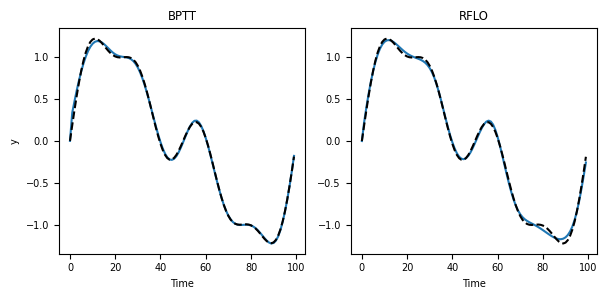

In [ ]:
# Test the networks with learning turned off:
y1, _, _ = net1.run_trial(x_tonic, y_target, learning=False)
y2, _, _ = net2.run_trial(x_tonic, y_target, learning=False)
#y3, _, _ = net3.run_trial(x_tonic, y_target, learning=False)

import matplotlib.pyplot as plt


# Plot the RNN output along with the target output:
plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.plot(y1)
plt.plot(y_target, '--k')
plt.title('BPTT')
plt.ylabel('y')
plt.xlabel('Time')

plt.subplot(132)
plt.plot(y2)
plt.plot(y_target, '--k')
plt.title('RFLO')
plt.xlabel('Time')

#plt.subplot(133)
#plt.plot(y3)
#plt.plot(y_target, '--k')
#plt.title('RTRL')
#plt.xlabel('Time')

plt.tight_layout()
plt.show()
